# <font color='violet'> Exploration & Parsing
Using prescription drug review data wrangled here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/2-kl-wrangle_duplicates.ipynb

In [1]:
# ! pip install tqdm 
# !{sys.executable} -m pip install contractions

In [2]:
import numpy as np
import pandas as pd
import sys
import contractions
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import unicodedata
from collections import Counter

In [3]:
# prepare to add local python functions; import modules from src directory
src = '../src'
sys.path.append(src)

# import local functions
from nlp.parse import remove_accented_chars, strip_most_punc, strip_apostrophe, \
strip_non_emoji_emoji_symbol

In [4]:
df = pd.read_csv('../data/interim/studies_no_duplicates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  31559 non-null  int64  
 1   rating      31559 non-null  float64
 2   condition   31559 non-null  object 
 3   review      31559 non-null  object 
 4   date        31559 non-null  object 
 5   drug0       31559 non-null  object 
 6   drug1       18992 non-null  object 
 7   drug2       32 non-null     object 
 8   drug3       23 non-null     object 
 9   drug4       12 non-null     object 
 10  drug5       11 non-null     object 
 11  drug6       7 non-null      object 
 12  drug7       5 non-null      object 
 13  drug8       3 non-null      object 
 14  drug9       2 non-null      object 
 15  drug10      2 non-null      object 
 16  drug11      2 non-null      object 
 17  drug12      2 non-null      object 
 18  drug13      2 non-null      object 
 19  drug14      1 non-null   

In [5]:
# Drop "Unnamed" column; it's redundant with the index
df = df.drop(columns=['Unnamed: 0'])
df.head(2)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,drug6,drug7,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15
0,9.0,add,I had began taking 20mg of Vyvanse for three m...,0,vyvanse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.0,add,Switched from Adderall to Dexedrine to compare...,0,dextroamphetamine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color='violet'> Explore each column, starting with drug columns

In [6]:
# drug0 holds the name of the most-commonly reviewed drug reviewed for a particular row
# How many are there?
len(set(df.drug0))

368

In the previous notebook, I saw that there were 633 total unique drugs. About 60% of them are represented in the drug0 column, but I'd like to explore using a list of all drugs contained in drug0:drug15 

In [7]:
all_drugs = df.loc[:,['drug0','drug1','drug2','drug3','drug4','drug5','drug6','drug7','drug8',
                'drug9','drug10','drug11','drug12','drug13','drug14','drug15'
                     ]].values.flatten()
all_drugs

array(['vyvanse', nan, nan, ..., nan, nan, nan], dtype=object)

In [8]:
all_drugs = list(all_drugs)
all_drugs = [d for d in all_drugs if str(d) != 'nan']
all_drugs[:10]

['vyvanse',
 'dextroamphetamine',
 'vyvanse',
 'saizen',
 'zyprexa',
 'vyvanse',
 'vyvanse',
 'ritalin-la',
 'wellbutrin-sr',
 'concerta']

In [9]:
counter = Counter(all_drugs)
counter_sorted = counter.most_common()
freq_drugs = counter_sorted[:10]
freq_drugs = list(dict(freq_drugs).keys())
freq_drugs

['sertraline',
 'escitalopram',
 'citalopram',
 'bupropion',
 'lexapro',
 'venlafaxine',
 'varenicline',
 'zoloft',
 'quetiapine',
 'clonazepam']

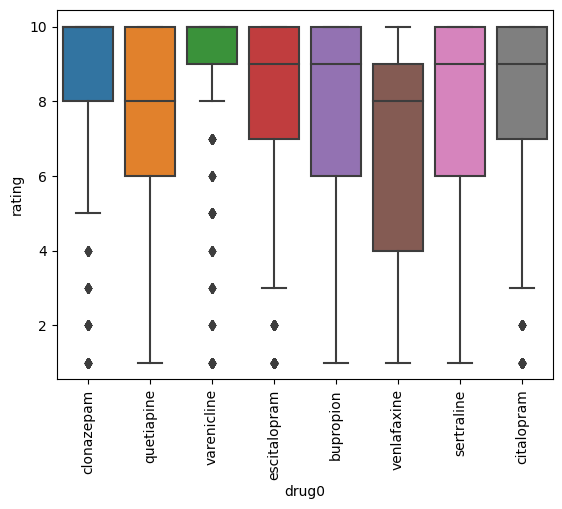

In [10]:
# How do ratings compare among these most frequently-reviewed drugs?
sns.boxplot(data=df[df['drug0'].isin(freq_drugs)], x='drug0', y='rating')
plt.xticks(rotation=90)
plt.show()

Alternatively, drugs could be understood by the conditions they treat. For these purposes going forward, just use the drug0 column since it does contain most of the most common drugs. 

<font color='violet'> Explore conditions

In [11]:
len(df.condition.unique())

38

In [12]:
freq_conditions = df.condition.value_counts().head(10)
freq_conditions

anxiety          9113
depression       8367
insomnia         3488
bipolar          3270
addiction        3074
hrt               854
other             590
ocd               479
schizophrenia     437
ptsd              313
Name: condition, dtype: int64

In [13]:
freq_conditions = ['anxiety', 'depression', 'insomnia', 'bipolar', 'addiction', 'hrt',
                  'other', 'ocd', 'schizophrenia', 'ptsd']

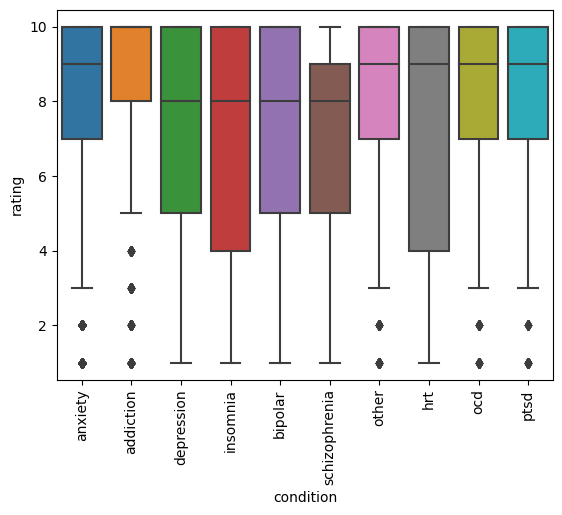

In [14]:
# According to ratings, how relatively well are any drugs treating these conditions?
sns.boxplot(data=df[df['condition'].isin(freq_conditions)], x='condition', y='rating')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Which of the most common drugs are usually used to treat which of the most common conditions?
freq_drug_conditions = df[df['drug0'].isin(freq_drugs) & df['condition'].isin(freq_conditions)]

freq_drug_conditions.groupby(['condition','drug0']).count()['rating']

condition      drug0       
addiction      bupropion        199
               clonazepam        17
               varenicline     1078
               venlafaxine        1
anxiety        bupropion         85
               citalopram       704
               clonazepam       776
               escitalopram    1057
               quetiapine       100
               sertraline       840
               venlafaxine      432
bipolar        bupropion         41
               citalopram         8
               clonazepam        77
               escitalopram      33
               quetiapine       394
               sertraline        32
               venlafaxine       50
depression     bupropion        892
               citalopram       535
               escitalopram     565
               quetiapine       130
               sertraline       763
               venlafaxine      690
hrt            bupropion          3
               citalopram        14
               escitalopram       8


In [16]:
drugs_to_treat_freq_cond = list(freq_drug_conditions.drug0.unique())
drugs_to_treat_freq_cond

['varenicline',
 'clonazepam',
 'escitalopram',
 'bupropion',
 'venlafaxine',
 'sertraline',
 'quetiapine',
 'citalopram']

In [17]:
freq_combo_dist = freq_drug_conditions.pivot_table(index='condition', columns='drug0', 
                                                      aggfunc='count', values='review')
freq_combo_dist.columns = drugs_to_treat_freq_cond
freq_combo_dist = freq_combo_dist.sort_values(by=drugs_to_treat_freq_cond, 
                                                    ascending=False)
freq_combo_dist

,varenicline,clonazepam,escitalopram,bupropion,venlafaxine,sertraline,quetiapine,citalopram
condition,,,,,,,,
depression,892.0,535.0,NaN,565.0,130.0,763.0,NaN,690.0
addiction,199.0,NaN,17.0,NaN,NaN,NaN,1078.0,1.0
anxiety,85.0,704.0,776.0,1057.0,100.0,840.0,NaN,432.0
bipolar,41.0,8.0,77.0,33.0,394.0,32.0,NaN,50.0
other,5.0,5.0,7.0,5.0,7.0,5.0,3.0,5.0
hrt,3.0,14.0,NaN,8.0,NaN,36.0,NaN,3.0
ocd,NaN,21.0,2.0,35.0,17.0,105.0,NaN,12.0
ptsd,NaN,3.0,NaN,NaN,34.0,67.0,NaN,13.0
insomnia,NaN,1.0,103.0,1.0,243.0,NaN,NaN,NaN


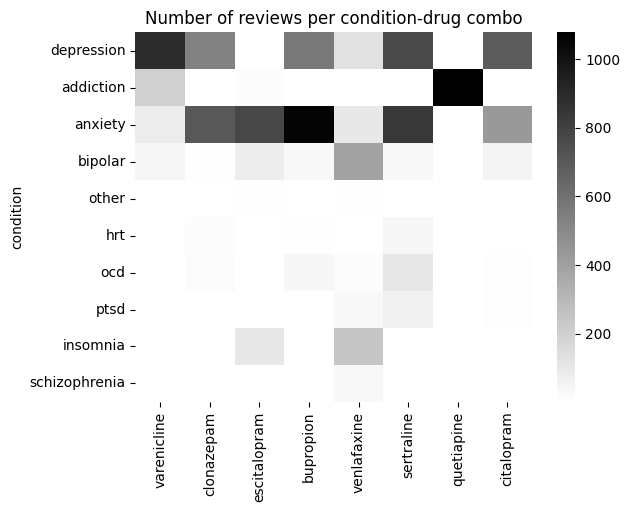

In [18]:
# Visualize distribution of reviews across common conditions & drugs with a heatmap.
sns.heatmap(freq_combo_dist, cmap='gray_r')
plt.title('Number of reviews per condition-drug combo')
plt.show()

In [19]:
# What about instead of distribution, find average rating for each drug-condition combo?
freq_drug_conditions.groupby(['condition','drug0']).mean()['rating']

/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_1163/2570916022.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  freq_drug_conditions.groupby(['condition','drug0']).mean()['rating']


condition      drug0       
addiction      bupropion        8.306533
               clonazepam       6.588235
               varenicline      8.802412
               venlafaxine     10.000000
anxiety        bupropion        7.105882
               citalopram       7.678977
               clonazepam       8.715206
               escitalopram     7.973510
               quetiapine       7.590000
               sertraline       7.553571
               venlafaxine      7.039352
bipolar        bupropion        6.902439
               citalopram       7.750000
               clonazepam       8.545455
               escitalopram     7.000000
               quetiapine       7.114213
               sertraline       7.281250
               venlafaxine      6.780000
depression     bupropion        7.353139
               citalopram       7.448598
               escitalopram     7.507965
               quetiapine       6.800000
               sertraline       7.193971
               venlafaxine   

In [20]:
freq_combo_rating = freq_drug_conditions.pivot_table(index='condition', columns='drug0', 
                                                      values='rating')
freq_combo_rating.columns = drugs_to_treat_freq_cond
freq_combo_rating = freq_combo_rating.sort_values(by=drugs_to_treat_freq_cond, 
                                                    ascending=False)
freq_combo_rating

,varenicline,clonazepam,escitalopram,bupropion,venlafaxine,sertraline,quetiapine,citalopram
condition,,,,,,,,
hrt,8.666667,9.214286,NaN,9.250000,NaN,8.666667,NaN,9.333333
addiction,8.306533,NaN,6.588235,NaN,NaN,NaN,8.802412,10.000000
depression,7.353139,7.448598,NaN,7.507965,6.800000,7.193971,NaN,6.600000
anxiety,7.105882,7.678977,8.715206,7.973510,7.590000,7.553571,NaN,7.039352
bipolar,6.902439,7.750000,8.545455,7.000000,7.114213,7.281250,NaN,6.780000
other,5.800000,8.600000,8.857143,7.200000,6.571429,9.400000,9.000000,6.800000
ptsd,NaN,10.000000,NaN,NaN,7.529412,7.477612,NaN,6.384615
insomnia,NaN,8.000000,7.543689,9.000000,7.942387,NaN,NaN,NaN
ocd,NaN,7.904762,9.000000,8.742857,8.529412,8.038095,NaN,8.000000


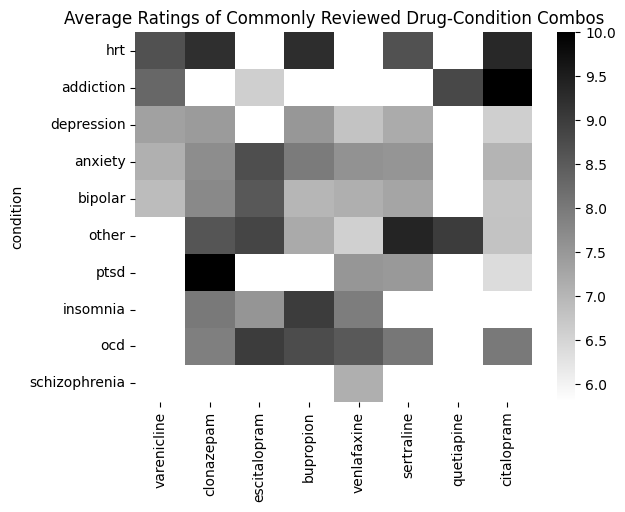

In [21]:
sns.heatmap(freq_combo_rating, cmap='gray_r')
plt.title('Average Ratings of Commonly Reviewed Drug-Condition Combos')
plt.show()

<font color='violet'> Which drugs & conditions have the highest ratings?

In [22]:
top_drugs = df.groupby(['drug0'])['rating'].mean().sort_values(ascending=False)
top_drugs.head(60)

drug0
hydrochlorothiazide / telmisartan            10.000000
tiagabine                                    10.000000
carisoprodol                                 10.000000
multivitamin with iron                       10.000000
acetaminophen / butalbital / caffeine        10.000000
mupirocin                                    10.000000
nabumetone                                   10.000000
thyroid desiccated                           10.000000
hydroxyurea                                  10.000000
pentobarbital                                10.000000
sodium hyaluronate                           10.000000
betamethasone                                10.000000
benzoyl peroxide                             10.000000
olodaterol                                   10.000000
hydrochlorothiazide / olmesartan             10.000000
aspirin / meprobamate                        10.000000
mometasone                                   10.000000
isotretinoin                                 10.000000
chan

In [23]:
successful_conditions = df.groupby(['condition'])['rating'].mean().sort_values(
    ascending=False)
successful_conditions.head(10)

condition
sad                  9.428571
failure to thrive    9.333333
did                  9.000000
addiction            8.638907
eating disorder      8.387097
ocd                  7.997912
other                7.937288
nightmares           7.854167
anxiety              7.715022
add                  7.654545
Name: rating, dtype: float64

In [24]:
top_combo = df.groupby(['drug0', 'condition'])['rating'].mean().sort_values(
    ascending=False)
top_combo.head(100)

drug0               condition      
propofol            other              10.000000
sodium hyaluronate  other              10.000000
doxylamine          other              10.000000
olanzapine          other              10.000000
olodaterol          other              10.000000
                                         ...    
niacin              depression          9.750000
tryptophan          insomnia            9.750000
nortriptyline       anxiety             9.666667
fluoxetine          eating disorder     9.666667
dimenhydrinate      insomnia            9.666667
Name: rating, Length: 100, dtype: float64

In [25]:
top_combo[90:100]

drug0                                      condition      
zolmitriptan                               other              10.000000
doxepin                                    other              10.000000
ethinyl estradiol / etonogestrel           other              10.000000
methadone                                  other               9.875000
esterified estrogens / methyltestosterone  hrt                 9.800000
niacin                                     depression          9.750000
tryptophan                                 insomnia            9.750000
nortriptyline                              anxiety             9.666667
fluoxetine                                 eating disorder     9.666667
dimenhydrinate                             insomnia            9.666667
Name: rating, dtype: float64

In [26]:
# How do the most highly-rated drugs fall among the most frequently-reviewed?
top_freq_drugs = set(freq_drugs).intersection(set(top_drugs.index[0:54]))
top_freq_drugs

set()

In [27]:
top_freq_drugs_by_condition = set(freq_drugs).intersection(set(top_combo.index[0:93]))
top_freq_drugs_by_condition

set()

In [28]:
# Do frequently-reviewed conditions overlap with those that are successfully treated?
successful_freq_conditions = set(freq_conditions).intersection(set(
    successful_conditions.index[0:10]))
successful_freq_conditions

{'addiction', 'anxiety', 'ocd', 'other'}

Anxiety, addction, and ocd are conditions for which there are many drug reviews and high rates of success with treatment. 

The 10 most frequently-reviewed drugs have nothing in common with the 54 perfectly-rated drugs or the 93 drugs that are rated perfectly for any single condition. My hypothesis is that these drugs may have only one or very few reviews each, which is how their average rating is so high. 

<font color='violet'> Explore distribution of ratings

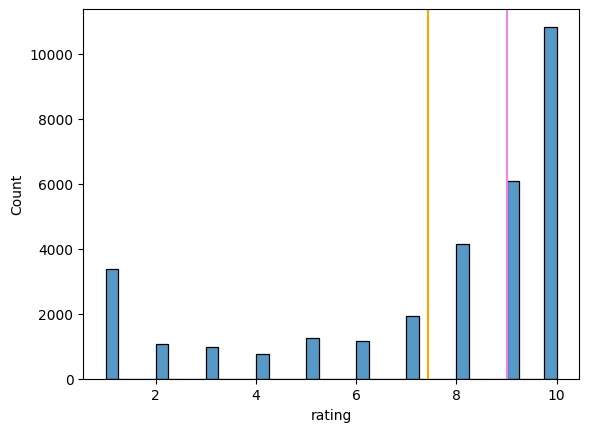

In [29]:
sns.histplot(df.rating)
plt.axvline(df.rating.mean(), color='orange')
plt.axvline(df.rating.median(), color='violet')
plt.show()

More participants gave their drug a high review than gave low reviews, and even fewer gave mediocre reviews.

Now, find out: of drugs that received an average rating of 10, how many reiews is that mean derived from?

In [30]:
perfect_avg_rating = set(top_drugs.index[0:54])
df[df.drug0.isin(perfect_avg_rating)].value_counts(subset='drug0')[0:7]

drug0
secobarbital          6
magnesium citrate     4
estropipate           3
ciprofloxacin         2
chantix               2
isotretinoin          2
thyroid desiccated    1
dtype: int64

Of the 54 drugs with perfect average ratings, only 6 of them had more than one rating, and only 3 of them had 3 or more ratings. Given that there are about 50500 ratings and 650 drugs, the average number of ratings per drug is about 80, so the perfectly-rated drugs definitely seem like outliers. I'd not be surprised if a model eventually has a difficult time correctly classifying the extreme ratings, but for now I'll just keep this in mind and see what happens. 

<font color='violet'> What does the distribution of ratings look like for drugs with at least 20 ratings (20 = 25% of the average number of ratings)?

In [31]:
df['ratings_count'] = df.groupby(['drug0'])['drug0'].transform('count')
df.sort_values('ratings_count')

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug7,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count
23170,8.0,other,"""I have been taking Atripla since it was appro...","October 28, 2008",efavirenz / emtricitabine / tenofovir,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
18072,5.0,other,"""Been on Forteo for a week. Rated a 5 - neutra...","August 22, 2008",teriparatide,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
27509,8.0,other,"""I&#039;ve been taking Novomix and I had to go...","October 28, 2008",glipizide,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
20115,8.0,other,"""I have been taking biotin for about three yea...","October 4, 2008",biotin,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
24757,1.0,other,"""Creatine was recommended to increase muscle t...","July 19, 2014",creatine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9781,8.0,anxiety,"""51 Yr old male, hardworker, dedicated, and pa...","November 20, 2010",sertraline,zoloft,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
13607,9.0,anxiety,"""I had my first panic attack almost two years ...","May 20, 2014",sertraline,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
29993,6.0,anxiety,"""I have been taking it for a month, side effec...","July 9, 2015",sertraline,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
9812,9.0,depression,"""This med helps me depression so much! I have ...","October 10, 2017",sertraline,zoloft,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855


In [32]:
twenty_plus_ratings = df[df.ratings_count>=20]
twenty_plus_ratings.sort_values('ratings_count')

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug7,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count
29799,10.0,hrt,"""Well it changed my life. I was only 43 and ev...","December 12, 2008",angeliq,drospirenone / estradiol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
25120,10.0,depression,"""I was taking welbutrin xl for depression. I ...","July 27, 2017",niacin,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
17496,8.0,alzheimers,"""My wife tried to add Namenda as a component o...","April 15, 2014",memantine,namenda xr,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
18070,10.0,depression,"""I have been on every ssri and different anti-...","December 4, 2015",niacin,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
24498,1.0,hrt,"""I am 55 years old and went through menapause ...","November 11, 2016",angeliq,drospirenone / estradiol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28630,7.0,anxiety,"""I have panic disorder along with Gemeralized ...","August 20, 2013",sertraline,zoloft,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
8851,8.0,ocd,"""It really helped me years ago when I took it ...","January 25, 2010",sertraline,zoloft,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
28638,9.0,depression,"""Been taking 50mg of Sertraline a day for abou...","March 30, 2016",sertraline,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855
11671,7.0,anxiety,"""Well I&#039;ve been taking Zoloft for anxiety...","May 4, 2016",sertraline,zoloft,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855


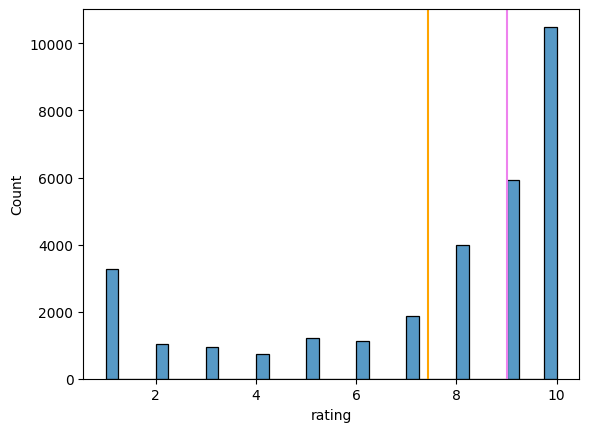

In [33]:
sns.histplot(twenty_plus_ratings.rating)
plt.axvline(df.rating.mean(), color='orange')
plt.axvline(df.rating.median(), color='violet')
plt.show()

This distribution doesn't look much different from that which includes all reviews, which tells me the outliers aren't affecting the distribution too much. So it's probably a good idea to keep all rows in the dataset when moving forward.  

<font color='violet'> What is the relationship between date and reviews?

In [34]:
df.date.unique()

array(['0', 'February 28, 2012', 'October 18, 2016', ...,
       'January 13, 2009', 'December 12, 2017', 'December 12, 2009'],
      dtype=object)

In [35]:
df.date = df.date.replace('0', np.nan)
df.date

0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
                ...        
31554    September 13, 2017
31555         July 25, 2016
31556         July 17, 2016
31557       August 16, 2016
31558          May 31, 2015
Name: date, Length: 31559, dtype: object

In [36]:
df.date = pd.to_datetime(df.date)
df.date

0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
           ...    
31554   2017-09-13
31555   2016-07-25
31556   2016-07-17
31557   2016-08-16
31558   2015-05-31
Name: date, Length: 31559, dtype: datetime64[ns]

In [37]:
# Are there more or fewer reviews from any given point in time?
df['count_by_date'] = df.groupby(['date'])['date'].transform('count')
unique_dates = df.drop_duplicates(subset=['date'])
unique_dates.head()

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
0,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN
108,10.0,depression,"""I&#039;ve tried a few antidepressants over th...",2012-02-28,mirtazapine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,716,11.0
109,7.0,addiction,"""Ive been on Methadone for over ten years and ...",2016-10-18,methadone,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182,28.0
110,10.0,schizoaffective disorder,"""No problems, watch what you eat.""",2014-10-08,quetiapine,seroquel,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1061,12.0
111,2.0,insomnia,"""Ditto on rebound sleepless when discontinued....",2015-01-13,zolpidem,ambien,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625,5.0


In [38]:
df.describe()

,rating,ratings_count,count_by_date
count,31559.000000,31559.000000,31451.000000
mean,7.424855,766.035141,12.674223
std,3.067194,523.556743,6.538243
min,1.000000,1.000000,1.000000
25%,6.000000,288.000000,7.000000
50%,9.000000,716.000000,12.000000
75%,10.000000,1081.000000,17.000000
max,10.000000,1855.000000,35.000000


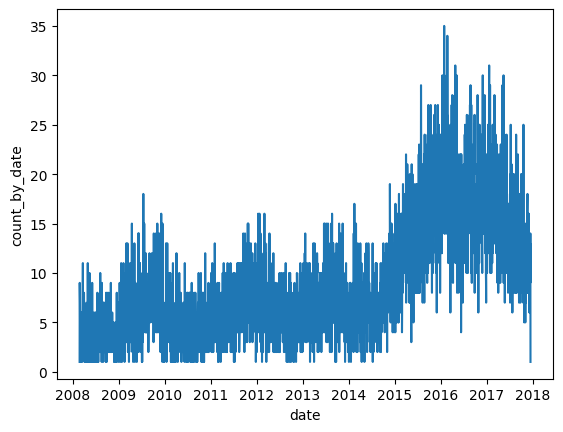

In [39]:
sns.lineplot(data=unique_dates, x='date', y='count_by_date')
plt.show()

There was an increase in the number of reviews submitted daily around 2015. 

<font color='violet'> Do ratings change with time?

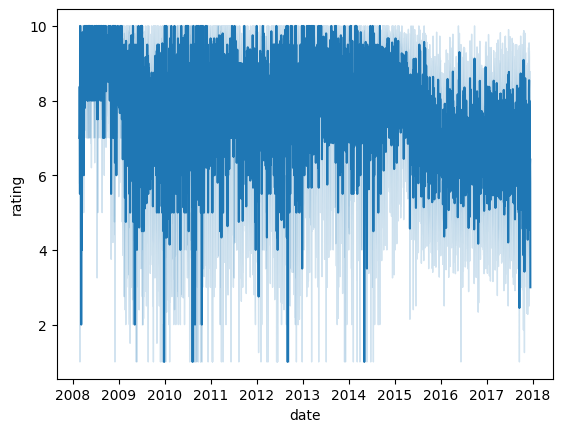

In [40]:
sns.lineplot(data=df, x='date', y='rating')
plt.show()

This looks like something other than total random noise, like maybe there were some current events happening around 2009 and again in 2015 that led people to start rating their psych meds less favorably. There may also be some annual seaonality. Whatever the reason, it seems that date could be correlated with rating and should not be removed. Process this column further to better understand the relationship between date and rating. 

In [41]:
rating_date = df[['date', 'rating']].dropna().set_index('date')
rating_date

,rating
date,
2012-02-28,10.0
2016-10-18,7.0
2014-10-08,10.0
2015-01-13,2.0
2015-02-14,10.0
...,...
2017-09-13,10.0
2016-07-25,3.0
2016-07-17,2.0


<AxesSubplot: xlabel='date'>

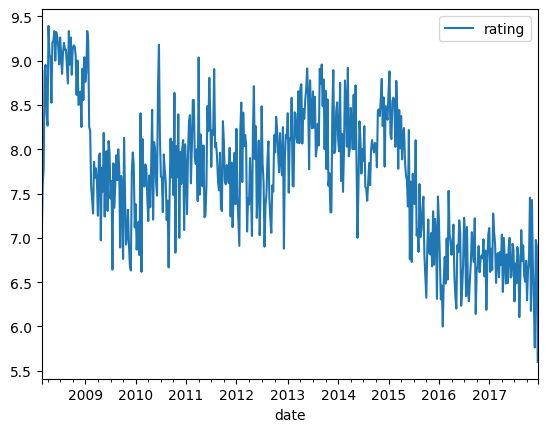

In [42]:
downsample_week = rating_date.resample('W').mean()
downsample_week.plot()

<AxesSubplot: xlabel='date'>

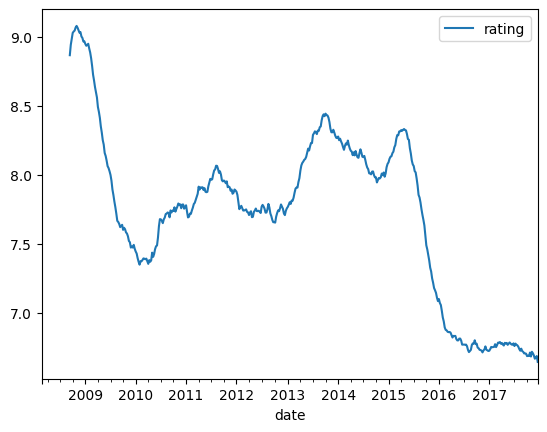

In [43]:
rolling_mean = downsample_week.rolling(window=30).mean()
rolling_mean.plot()

<AxesSubplot: xlabel='date'>

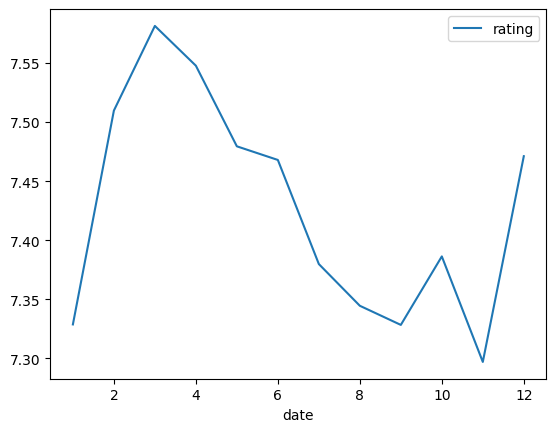

In [44]:
# Check for seasonality
index_month = rating_date.index.month
rating_by_month = rating_date.groupby(index_month).mean()
rating_by_month.plot()

It seems that seasonal variation is less extreme than variation by year (average range of 7.3-7.55 instead of 6.5-9.0), with people rating their drugs as being, on average, very slightly less effective in July-November. 

It is even more clear now that weekly average ratings of drugs in these studies did in facat dip in 2009 and again in 2015. The purpose behind these trends isn't so important (though I have some guesses as to what was happening in 2009 and 2015). The date, though, will be a valuable variable alongside narrataive text features when predicting ratings, so as to compare like with like current-events wise. 

Now, move from the more quantitative data into the narrative column, cleaning up language therein. 

<font color='violet'> Parse Language
    
The review column contains narratives where patients explain their experience with a prescription psych med. Language features from that column need to be extracted or created after any necessary cleaning of strings has been completed. Do any preparations necessary to conduct sentiment analysis. I'll be drawing quite a bit from the following resource: https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

In [45]:
# View a sample string. Search for special characters.
df.review[0]

'I had began taking 20mg of Vyvanse for three months and was surprised to find that such a small dose affected my mood so effectively.  When it came to school work though I found that I needed the 30mg to increase my level of focus (and have been on it for a month since).  I had not experienced decreased appetite until about a month into taking the 20mg.  I find that the greatest benefit of Vyvanse for me is that it tends to stabalize my mood on a daily basis and lessens any bouts of anxiety and depression that i used to face before I was perscribed. a few experiences of nausiea, heavy moodswings on the days I do not take it, decreased appetite, and some negative affect on my short-term memory. My mood has noticably improved, I have more energy, experience better sleep and digestion.'

In [46]:
df[df['review'].str.find("é")!=-1].head(1)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date


In [47]:
df[df['review'].str.find("ä")!=-1].head(1)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date


<font color='violet'> Remove Most Special Characters

...if there are any. Haven't been able to find any of the most common special characters é or ä in the data, but doing it just in case. 

In [48]:
# This function works in the test suite, but there may not be examples in the data
df['review'] = df['review'].apply(remove_accented_chars)

<font color='violet'> Expand Contractions

In [49]:
# First, find some to confirm it works. 
df[df['review'].str.find("'")!=-1].head(1)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
9,8.0,adhd,The treatment details were pretty basic. I ju...,NaT,concerta,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN


In [50]:
df.review[9]

"The treatment details were pretty basic.  I just took the medication in the morning at the same time of day every day.  I was allowed to skip it on the weekends or less busy times if I so desired.  I really don't have anything else to put for this section of the survey.  I'm trying to fill up the 50 word requirement though.  You shouldn't really have that requirement on this form.  It seems kind of silly to be writing with nothing left to say. Some of the side affects that I had were:  my stomach would hurt sometimes and other times it was difficult to eat without getting queezy.  I didn't have much of an appetite.  When the medicine wore off, it seemed to have a strong rebound effect and things became difficult for me during that last several hours of my day. I liked taking the medication, I just wish it would have lasted longer during the day.  By 3p-5pm it had wore off and that seemed to by my busiest time of day with the kids, dinner and house stuff all at once. I did not have any

In [51]:
df['review'] = df['review'].apply(contractions.fix)
df.review[9]

'The treatment details were pretty basic.  I just took the medication in the morning at the same time of day every day.  I was allowed to skip it on the weekends or less busy times if I so desired.  I really do not have anything else to put for this section of the survey.  I am trying to fill up the 50 word requirement though.  You should not really have that requirement on this form.  It seems kind of silly to be writing with nothing left to say. Some of the side affects that I had were:  my stomach would hurt sometimes and other times it was difficult to eat without getting queezy.  I did not have much of an appetite.  When the medicine wore off, it seemed to have a strong rebound effect and things became difficult for me during that last several hours of my day. I liked taking the medication, I just wish it would have lasted longer during the day.  By 3p-5pm it had wore off and that seemed to by my busiest time of day with the kids, dinner and house stuff all at once. I did not have

"Don't" got changed to "do not"; contraction expansion worked. 

<font color='violet'> Remove punctuation/special characters where appropriate. 
    
Try to keep those correlated with sentiment: ! ? # % ;) :( .  Again, first find an example to confirm it works.

In [52]:
df[df['review'].str.find("!")!=-1].head(1)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
6,7.0,add,So far the throwing up has stopped and the hea...,NaT,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN


In [53]:
df.review[6]

'So far the throwing up has stopped and the headaches come and go no food even looks good to eat no cravings very easy to diet ;) and passing all my finals was AMAZING. This drug makes strattera look like tylenol! throwing up alot, bad headaches, twitching, crazy heart beat, loss of appetite (which is a plus in my eyes), and happy thoughts (like "wow i am soo beautiful" for some reason would pop in my head alot), as well as some negative thoughts and worrying about homework constantly which is fine to because i would get it all done. I needed to switch from straterra which made me very very depressed quiet and i slept for like an hour each night with that drug it was horrible. I switched to Vyvanse and the first time i took it, it was like an anti deppresant at first i was the normal happy hyper me but i could still focus very well on studying but when i started comming down from it that was the worst i was dry heaving with a TERRIBLE HEADACHE for an hour and then i would just throw ev

In [54]:
# Use function from package I made to get rid of most of the punctuation.
strip_most_punc(df, 'review')
df.review[6]

100%|██████████| 31559/31559 [00:25<00:00, 1261.12it/s]


'So far the throwing up has stopped and the headaches come and go no food even looks good to eat no cravings very easy to diet ;) and passing all my finals was AMAZING This drug makes strattera look like tylenol! throwing up alot bad headaches twitching crazy heart beat loss of appetite (which is a plus in my eyes) and happy thoughts (like wow i am soo beautiful for some reason would pop in my head alot) as well as some negative thoughts and worrying about homework constantly which is fine to because i would get it all done I needed to switch from straterra which made me very very depressed quiet and i slept for like an hour each night with that drug it was horrible I switched to Vyvanse and the first time i took it it was like an anti deppresant at first i was the normal happy hyper me but i could still focus very well on studying but when i started comming down from it that was the worst i was dry heaving with a TERRIBLE HEADACHE for an hour and then i would just throw everything up 

Does stripping punctuation produce more duplicates? It would make sense if it does because some reviews, especially very short ones, may have only been different by a single punctuation character. It's probably fine to leave duplicated reviews in this case, as they were originally separate and have different condition-review-date-drug combinations

In [55]:
df[df.review.duplicated(keep=False)==True].sort_values(by='review')

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
30993,10.0,anxiety,Excellent,2012-07-19,tramadol,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141,5.0
320,9.0,insomnia,Excellent,2015-02-25,escitalopram,lexapro,venlafaxine,venlafaxine,trazodone,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1711,15.0
214,10.0,other,Good,2011-11-23,sertraline,citalopram,alprazolam,celexa,xanax,lorazepam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855,8.0
7215,10.0,psychosis,Good,2011-02-26,escitalopram,citalopram,lexapro,quetiapine,quetiapine,clonazepam,...,mirtazapine,celexa,xanax,lorazepam,chlorpromazine,thorazine,famotidine,famotidine,1711,6.0
6240,7.0,anxiety,Good medicine,2016-12-30,buspirone,buspar,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619,16.0
17562,9.0,anxiety,Good medicine,2014-04-26,clonazepam,klonopin,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.0
211,10.0,bipolar,Great,2013-09-27,clonazepam,alprazolam,xanax,lorazepam,klonopin,ativan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,10.0
10600,8.0,insomnia,Great,2017-05-11,citalopram,citalopram,varenicline,chantix,zolpidem,pregabalin,...,tylenol pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1295,25.0
23906,9.0,addiction,Helps,2016-04-23,buprenorphine / naloxone,suboxone,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,13.0
20455,10.0,anxiety,Helps,2009-03-28,alprazolam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,882,8.0


In [56]:
# left to strip are ' and : ; () where they don't appear as emoji.

df[df['review'].str.find("'")!=-1].head(1)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
16,8.0,add,Diagnosed with Adult ADD I first took Ritalin ...,NaT,adderall,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN


In [57]:
df.review[16]

"Diagnosed with Adult ADD I first took Ritalin I found this to cause some 'nervousness' and to have peaks  valleys I switched to Adderall XR and find I notice no physical symptoms only an increase in positive mood and desire to accomplish the days work The effect does seem to peak soon after the dose slowly level out and at about 68 hrs after initial dose I feel calm but now enthusiastic as earlier in the day None noticeable Increased interest and enthusiasm in activities"

In [58]:
strip_apostrophe(df, 'review')
df.review[16]

100%|██████████| 31559/31559 [00:19<00:00, 1638.95it/s]


'Diagnosed with Adult ADD I first took Ritalin I found this to cause some nervousness and to have peaks  valleys I switched to Adderall XR and find I notice no physical symptoms only an increase in positive mood and desire to accomplish the days work The effect does seem to peak soon after the dose slowly level out and at about 68 hrs after initial dose I feel calm but now enthusiastic as earlier in the day None noticeable Increased interest and enthusiasm in activities'

Stripping apostrophes worked. 

<font color='violet'> Zoom in on characters that are commonly used in emoji and remove them where they don't appear as part of an emoticon. 
    
Now remove :;() when they appear next to a letter, not emoji. This isn't a perfect solution, as many characters that I already removed can get used in emoji, but at least the most common emoji will be preserved. I'm not going to search for places where these appear next to numbers because my assumption is that symbols appear next to numbers more often as emoji, compared with letters which appear more often next to symbols used for basic punctuation. 
    
Row 6 from earlier has an emoji ;) as well as other ( and ) symbols. Where might I find some other : and ; to see if I'm successfully removing them?

In [59]:
df[df['review'].str.find(":")!=-1].head(2)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
9,8.0,adhd,The treatment details were pretty basic I jus...,NaT,concerta,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN
13,8.0,add,With or without this medication I am a philoso...,NaT,strattera,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN


In [60]:
df.review[13]

'With or without this medication I am a philosopher So I will be explain how the drug works on me from a philosophical assessment\r\r\n\r\r\nBackground:\r\r\nI had taken Strattera for three years (20052007) where it helped control ADD where I had difficulty doing so It helped me focus stay organized manage relations and most or all of the benefits I listed prior I dropped the drug for 3 years so that I may learn how to control my ADD without the help of medication During those three years I gained remarkable self control in overcoming ADD However I got to the point where I could not win over ADD which was losing focus randomly During college lectures that I found very intriguing I would often zone outspace out when I could not have been more interested in what was being professed The frustration of this led me to conclude that medical assistance was the best choice\r\r\n\r\r\nOn the drug:\r\r\nI read and understand that the (generally) biggest conside effectto this drug is that there i

In [61]:
# That example has lots of weird stuff going on; deal with that eventually if necessary.
# For now I can at lease see where the : is (row 2) and check if my function below delets it
# Finally, find an example of ;

df[df['review'].str.find(";")!=-1].head(2)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
6,7.0,add,So far the throwing up has stopped and the hea...,NaT,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN
25,9.0,add,Have tried Ritalin for ADD and while it worked...,NaT,provigil,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN


In [62]:
df.review[25]

'Have tried Ritalin for ADD and while it worked the stimulant effect was disturbing and way too much  Wellbutrin seemed to not do a thing but after 1 week of taking provigil the effect was enourmously obvious Mild headaches occasionally when the drug wore off; smelly urine; occasionally insomnia depending on what time the drug was first taken After adjusting to the medication focus and alertness improved significantly  Fatigue and trouble becoming bored disappeared and I was ablve to focus on school studies and work for the first time in many many years  No stimulant effect was felt but it even became fun to actually sit down on a couch and just read a book'

I caused some problems with implementation of my final parsing function, and I don't want to need to re-run prior cells every time I work through debugging, so create a copy of the df just for applying this function. And make sure after running it that no duplicate reviews were created in error. 

In [63]:
to_strip_of_emoji = df.copy().reset_index(drop=True)
to_strip_of_emoji.head(3)

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
0,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaT,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN
1,8.0,add,Switched from Adderall to Dexedrine to compare...,NaT,dextroamphetamine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN
2,8.0,adhd,I have only been on Vyvanse for 2 weeks I sta...,NaT,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76,NaN


In [64]:
# Look at a spot where reviews have been duplicated in error while building this function. 
# What should it look like? 
to_strip_of_emoji.loc[25269:25272,:]

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
25269,1.0,bipolar,Caused depression and negative self defeating...,2016-08-25,quetiapine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1061,20.0
25270,10.0,anxiety,I have been on Cymbalta for 6 years It was a l...,2011-08-16,duloxetine,cymbalta,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,788,4.0
25271,4.0,bipolar,I have just started taking Saphris 5 mg in the...,2011-12-17,asenapine,saphris,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,5.0
25272,1.0,other,I only took it for 3 days and after I stopped ...,2008-12-02,venlafaxine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1210,3.0


In [65]:
# Note: the ; in that last example above shows up in the third to last row.
# Use a function that can remove these characters appropriately
strip_non_emoji_emoji_symbol(to_strip_of_emoji,'review')

100%|██████████| 31559/31559 [00:23<00:00, 1323.23it/s]


In [66]:
# Make sure the function works properly and isn't overwriting/ creating duplicates in error.
to_strip_of_emoji[to_strip_of_emoji.review.duplicated(keep=False)==True].sort_values(
    by='review')

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug8,drug9,drug10,drug11,drug12,drug13,drug14,drug15,ratings_count,count_by_date
30993,10.0,anxiety,Excellent,2012-07-19,tramadol,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141,5.0
320,9.0,insomnia,Excellent,2015-02-25,escitalopram,lexapro,venlafaxine,venlafaxine,trazodone,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1711,15.0
214,10.0,other,Good,2011-11-23,sertraline,citalopram,alprazolam,celexa,xanax,lorazepam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1855,8.0
7215,10.0,psychosis,Good,2011-02-26,escitalopram,citalopram,lexapro,quetiapine,quetiapine,clonazepam,...,mirtazapine,celexa,xanax,lorazepam,chlorpromazine,thorazine,famotidine,famotidine,1711,6.0
6240,7.0,anxiety,Good medicine,2016-12-30,buspirone,buspar,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,619,16.0
17562,9.0,anxiety,Good medicine,2014-04-26,clonazepam,klonopin,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9.0
211,10.0,bipolar,Great,2013-09-27,clonazepam,alprazolam,xanax,lorazepam,klonopin,ativan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,10.0
10600,8.0,insomnia,Great,2017-05-11,citalopram,citalopram,varenicline,chantix,zolpidem,pregabalin,...,tylenol pm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1295,25.0
23906,9.0,addiction,Helps,2016-04-23,buprenorphine / naloxone,suboxone,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,13.0
20455,10.0,anxiety,Helps,2009-03-28,alprazolam,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,882,8.0


In [67]:
# The only duplicates are those that should be present, created above when basic 
# punctuation was stripped. Did this do what I wanted in target reviews?
to_strip_of_emoji.review[6]

'So far the throwing up has stopped and the headaches come and go no food even looks good to eat no cravings very easy to diet ;) and passing all my finals was AMAZING This drug makes strattera look like tylenol! throwing up alot bad headaches twitching crazy heart beat loss of appetite  which is a plus in my eyes  and happy thoughts  like wow i am soo beautiful for some reason would pop in my head alot  as well as some negative thoughts and worrying about homework constantly which is fine to because i would get it all done I needed to switch from straterra which made me very very depressed quiet and i slept for like an hour each night with that drug it was horrible I switched to Vyvanse and the first time i took it it was like an anti deppresant at first i was the normal happy hyper me but i could still focus very well on studying but when i started comming down from it that was the worst i was dry heaving with a TERRIBLE HEADACHE for an hour and then i would just throw everything up 

In [68]:
# The ;) is intact, but all other parentheses that had been in the string from row 6 are gone!
# Check on the two other strings.
to_strip_of_emoji.review[13]

'With or without this medication I am a philosopher So I will be explain how the drug works on me from a philosophical assessment\r\r\n\r\r\nBackground \r\r\nI had taken Strattera for three years (20052007) where it helped control ADD where I had difficulty doing so It helped me focus stay organized manage relations and most or all of the benefits I listed prior I dropped the drug for 3 years so that I may learn how to control my ADD without the help of medication During those three years I gained remarkable self control in overcoming ADD However I got to the point where I could not win over ADD which was losing focus randomly During college lectures that I found very intriguing I would often zone outspace out when I could not have been more interested in what was being professed The frustration of this led me to conclude that medical assistance was the best choice\r\r\n\r\r\nOn the drug \r\r\nI read and understand that the  generally  biggest conside effectto this drug is that there i

In [69]:
to_strip_of_emoji.review[25]

'Have tried Ritalin for ADD and while it worked the stimulant effect was disturbing and way too much  Wellbutrin seemed to not do a thing but after 1 week of taking provigil the effect was enourmously obvious Mild headaches occasionally when the drug wore off  smelly urine  occasionally insomnia depending on what time the drug was first taken After adjusting to the medication focus and alertness improved significantly  Fatigue and trouble becoming bored disappeared and I was ablve to focus on school studies and work for the first time in many many years  No stimulant effect was felt but it even became fun to actually sit down on a couch and just read a book'

The colon after background in review 13 is gone, and the semicolon from review 25 after "urine" was removed. 

There is much that yet needs to be done to process the review texts. Continue that more in-depth NLP and EDA in the next notebook: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/4-kl-studies-nlp-eda.ipynb

In [70]:
# Save data as is
to_strip_of_emoji.to_csv('../data/interim/studies_early_parsing.csv')